# Determine BATCH II Scan Errors

#### Updated: April 24, 2023 by Ashley Ferreira

#### Setup 
You will likely need to pip install tensorflow and keras_ocr as they do not come by default with anaconda, uncomment the cells below to do this if needed. Then run the cells to import the libraries adn set some of the default parameters.

In [ ]:
#! pip install tensorflow --user

In [ ]:
#! pip install keras_ocr --user

In [2]:
#! pip install line_profiler

In [ ]:
#! pip install easyocr

In [4]:
# enter your network username to have correct paths
username = 'aferreira'

In [5]:
# imports
import cv2
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import gc
from PIL import Image
#from numba import jit, cuda, njit

# replace this with your own library path for --user pip installs
sys.path.append('C:/Users/' + username + '/AppData/Roaming/Python/Python38/Scripts')
import keras_ocr

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline()

In [14]:
%load_ext line_profiler
print(os.cpu_count())

4


In [6]:
# set paths
batchDir = 'L:/DATA/Alouette_I/BATCH_II_raw/'
save_dir = 'U:/Downloads/April23/' #test_runs/' 
outFile = save_dir + 'notebook20_outputs_v15.csv'

# set default saving settings
append2outFile = True
saveImages = False

#### Inititalize functions
The main processing for this code uses two functions, read_all_rolls() which loops over all the batch 2 raw data ionogram images and saves the outputs from read_image() to a CSV file. This second function, read_image() reads in one image a time, whos path is passed it it by read_all_rolls(), and outputs the height and width along with the estimated digit count of the metadata. 

In [45]:
from io import BytesIO

def convertToJpeg(im):
    with BytesIO() as f:
        im.save(f, format='JPEG')
        return f.getvalue()

image = convertToJpeg(image)

Playing around with downsizing the image and found that 2-4 factors of downsizing in likely sweet spot where time taken for inference is significantly reduced but also image is somewhat legible still. Could alternatively decide on set length of one axis and then just scale the other accordingly or have different downscales for large and small images. Image library can likely allow for better interpolation but is not easily compatible with keras_ocr.

(3672, 832)
1/1 [==============================] - 1s 1s/step


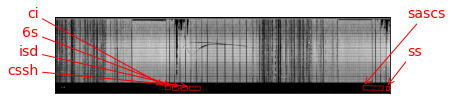

digits count: 18


(18, 832, 3672, False)

In [58]:
image_path = batchDir + 'R014207709' + '/' + 'C-111-50' + '/' + '9.png'
read_image(image_path)

In [57]:
def read_image(image_path, down_factor=2):
    '''
    '''
    try: 

        # read in image using keras_ocr
        image = keras_ocr.tools.read(image_path) 

        # extract height and width of image in pixels 
        height, width = image.shape[0], image.shape[1]

        # cut image to just include bottom 20% of pixels
        cropped_height = height-height//5
        #cropped_image = [image[cropped_height:height,:]]

        down_size = (width//down_factor, height//down_factor)
        image = cv2.resize(image, down_size)

        # create predictions for location and value of characters
        # on the cropped image, will output (word, box) tuples
        prediction = pipeline.recognize([image])[0]

        # TEMP (using for testing)
        #keras_ocr.tools.drawAnnotations(image=image, predictions=prediction)
        #plt.show()

        # if no characters are found move on
        if prediction == [[]]:
            digit_count = 0

        # if characters are found look at the predictions
        else:

            # loop over predicted (word, box) tuples and count number of digit characters
            digit_count = 0
            says_isis = False
            for p in prediction:

                # select word and box part of the tuple
                value, box = p[0], p[1]

                # check for 'isis' of any capitalization in image
                # (can do the text detection process more efficiently)
                if 'isis' in value.lower(): # may want to check 1, I, 5 variations on this
                    says_isis = True
                    print('found potential ISIS text')
                

                # check that box is within the cropped height
                in_bounds = True
                for b in box:
                    if b[1] < cropped_height:
                        in_bounds = False
                        break
                        
                if in_bounds:
                    digit_count += len(value)

        print('digits count:', digit_count)

    except Exception as e:
        print('ERR:', e)
        digit_count, height, width, says_isis = 'ERR', 'ERR', 'ERR', 'ERR'

    return digit_count, height, width, says_isis

In [8]:
def read_all_rolls(outFile=outFile, append2outFile=True, batchDir=batchDir, max_images=None, save_each=100):
   '''
   This function loops over all images nested within batchDir
   and saves the outputs from read_image() to a CSV file.

   Parameters:

      outFile (str, optional): path to CSV file where results from this 
                               function can be stored 

      append2outFile (bool, optional): if True will append to data in outFile 
                                       (if any exists), otherwise overwrites

      batchDir (str, optional): path to directory of entire batch 
                                of ionogram scan images to analyze

      saveImages (bool, optional): True to save all images with irregular
                                    aspect ratios for visual inspection, 
                                    False otherwise

      max_images (int, optional): maximum number of images used to iterate over

      save_each (int, optional): save results to CSV after this number of images

   Returns:

      None

   '''
   # check if there is already data in the output file 
   if os.path.exists(outFile) and os.path.getsize(outFile)!=0:
      found = False
      header = False 

      df = pd.read_csv(outFile)
      last_entry = batchDir + df['roll'].iloc[-1] + '/' + df['subdir'].iloc[-1] + '/' + df['image'].iloc[-1]
      del df 
      # Returns the number of
      # objects it has collected
      # and deallocated
      collected = gc.collect()
      
      # Prints Garbage collector
      # as 0 object
      print("Garbage collector: collected",
               "%d objects." % collected)

   else: 
      found = True
      header = True
      last_entry = ''

   # initialize lists to save values to in loop
   rolls, subdirs, images = [], [], []
   heights, widths, digit_counts = [], [], []
   says_isis_lst = []

   images_saved = 0
   
   # loop over all rolls in the batch 2 raw data directory
   raw_contents = os.listdir(batchDir)
   for roll in raw_contents:

      # loop over all subdirectories within the roll
      roll_contents = os.listdir(batchDir + roll) 
      for subdir in roll_contents:
         
         # loop over all images in the subdirectory
         subdir_contents = os.listdir(batchDir + roll + '/' + subdir) 
         for image in subdir_contents:

            # save full path of image
            image_path = batchDir + roll + '/' + subdir + '/' + image

            # skip over image if already analyzed in CSV
            if found == False and last_entry == image_path:
               found = True

            if found == True:
               images_saved += 1

               if max_images != None and images_saved > max_images:
                  sys.exit()

               # save id of image
               rolls.append(roll)
               subdirs.append(subdir)
               images.append(image)

               # send to read_image to get aspect ratio, digit count, and isis text
               num_of_digits, h, w, says_isis = read_image(image_path)

               # save values
               digit_counts.append(num_of_digits)
               heights.append(h)
               widths.append(w)
               says_isis_lst.append(says_isis)              

               # save to csv after a set number of images (perhaps best to make propto max images)
               if images_saved % save_each == 0:

                  # initialize dataframe and save results to csv
                  # (redoing this each interation to not loose information)
                  df_mapping_results = pd.DataFrame()

                  df_mapping_results['roll'] = rolls
                  df_mapping_results['subdir'] = subdirs
                  df_mapping_results['image'] = images
                  df_mapping_results['digit_count'] = digit_counts
                  df_mapping_results['height'] = heights
                  df_mapping_results['width'] = widths
                  df_mapping_results['says_isis'] = says_isis_lst

                  # mode = 'a' means it will append to existing data within the file
                  if append2outFile == True:
                     mode = 'a' 

                     # wipe lists now that they have been saved
                     rolls, subdirs, images = [], [], []
                     heights, widths, digit_counts = [], [], []
                     says_isis_lst = []
                     
                  else: 
                     # this overwrites existing file
                     mode = 'w'
                     header = True

                  df_mapping_results.to_csv(outFile, mode=mode, index=False, header=header)
                  del df_mapping_results

                  collected = gc.collect()
                  print("Garbage collector: collected",
                           "%d objects." % collected)

#### Running the functions
Below, I run the read_all_rolls() function for the batch 2 raw data directory and it saves the results as it processes.

In [10]:
# profile the read_all_rolls() function
# run it for 10 only to get results
%lprun -f read_all_rolls read_all_rolls(max_images=10, save_each=5)

Garbage collector: collected 21071 objects.
ERR: 'tuple' object cannot be interpreted as an integer
ERR: 'tuple' object cannot be interpreted as an integer
*** KeyboardInterrupt exception caught in code being profiled.

Timer unit: 1e-07 s

Total time: 3.21398 s
File: <ipython-input-8-a5f0c38dd8b5>
Function: read_all_rolls at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def read_all_rolls(outFile=outFile, append2outFile=True, batchDir=batchDir, max_images=None, save_each=100):
     2                                              '''
     3                                              This function loops over all images nested within batchDir
     4                                              and saves the outputs from read_image() to a CSV file.
     5                                           
     6                                              Parameters:
     7                                           
     8                                                 outFile (str, optional): path to CSV file where results from this 
     9                                                                          function can be stored 

In [13]:
# (just one iteration here)
image_path = batchDir + 'R014207709' + '/' + '145' + '/' + '1.png'
%lprun -f read_image read_image(image_path)

1/1 [==============================] - 2s 2s/step
digits count: 18


Timer unit: 1e-07 s

Total time: 45.2449 s
File: <ipython-input-6-be4c62cda9ae>
Function: read_image at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def read_image(image_path):
     4                                               '''
     5                                               '''
     6         1         20.0     20.0      0.0      try: 
     7                                           
     8                                                   # read in image using keras_ocr
     9         1    7477189.0 7477189.0      1.7          image = keras_ocr.tools.read(image_path) 
    10                                           
    11                                                   # extract height and width of image in pixels 
    12         1         84.0     84.0      0.0          height, width = image.shape[0], image.shape[1]
    13                                           
    14                      

In [12]:
# (just one iteration here)
image_path = batchDir + 'R014207709' + '/' + '145' + '/' + '10.png'
%lprun -f read_image read_image(image_path)

1/1 [==============================] - 8s 8s/step
digits count: 0


Timer unit: 1e-07 s

Total time: 15.3668 s
File: <ipython-input-11-e374146448d1>
Function: read_image at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def read_image(image_path):
     2                                               '''
     3                                               '''
     4         1          7.0      7.0      0.0      try: 
     5                                           
     6                                                   # read in image using keras_ocr
     7         1    3859733.0 3859733.0      2.5          image = keras_ocr.tools.read(image_path) 
     8                                           
     9                                                   # extract height and width of image in pixels 
    10         1         43.0     43.0      0.0          height, width = image.shape[0], image.shape[1]
    11                                           
    12                     

#### Multiprocessing & Multithreading Implimentations
Testing to see if either of these are a worthwhile approach. Multiprocessing was found to not work well off the batt but multithreading was good and maximizing CPU and memory usage but after a while CPU usage still goes down to only ~30% utlization and this significantly slows down performance.

In [15]:
from multiprocessing import Process
import threading

In [23]:
def read_all_rolls_alt2(roll, outFile=outFile, append2outFile=True, batchDir=batchDir, max_images=None, save_each=100):
   '''
   '''

   # initialize lists to save values to in loop
   rolls, subdirs, images = [], [], []
   heights, widths, digit_counts = [], [], []
   says_isis_lst = []

   images_saved = 0
   header = True
   last_entry = ''

   # loop over all subdirectories within the roll
   roll_contents = os.listdir(batchDir + roll) 
   for subdir in roll_contents:
      
      # loop over all images in the subdirectory
      subdir_contents = os.listdir(batchDir + roll + '/' + subdir) 
      for image in subdir_contents:

         # save full path of image
         image_path = batchDir + roll + '/' + subdir + '/' + image

         images_saved += 1

         if max_images != None and images_saved > max_images:
            sys.exit()

         # save id of image
         rolls.append(roll)
         subdirs.append(subdir)
         images.append(image)

         # send to read_image to get aspect ratio, digit count, and isis text
         num_of_digits, h, w, says_isis = read_image(image_path)

         # save values
         digit_counts.append(num_of_digits)
         heights.append(h)
         widths.append(w)
         says_isis_lst.append(says_isis)              

         # save to csv after a set number of images (perhaps best to make propto max images)
         if images_saved % save_each == 0:

            # initialize dataframe and save results to csv
            df_mapping_results = pd.DataFrame()

            df_mapping_results['roll'] = rolls
            df_mapping_results['subdir'] = subdirs
            df_mapping_results['image'] = images
            df_mapping_results['digit_count'] = digit_counts
            df_mapping_results['height'] = heights
            df_mapping_results['width'] = widths
            df_mapping_results['says_isis'] = says_isis_lst

            if header == True and os.path.getsize(outFile) != 0:
               header = False # for multithreading we need to check here

            # mode = 'a' means it will append to existing data within the file
            if append2outFile == True and header == False:
               mode = 'a' 

               # wipe lists now that they have been saved
               rolls, subdirs, images = [], [], []
               heights, widths, digit_counts = [], [], []
               says_isis_lst = []
               
            df_mapping_results.to_csv(outFile, mode=mode, index=False, header=header)
            del df_mapping_results

            collected = gc.collect()
            print("Garbage collector: collected",
                     "%d objects." % collected)

In [12]:
def print_roll(roll):
    print(roll)

In [13]:
test_rolls = [
    'R014207709', 
    'R014207711'
]

# create processes
processes = [Process(target=read_all_rolls_alt2, args=[roll]) 
            for roll in test_rolls]

# start the processes
for process in processes:
    process.start()

# wait for completion
for process in processes:
    process.join()

In [14]:
# Check process is running
process.is_alive()

False

In [ ]:
test_rolls = [
    'R014207709', 
    'R014207711', 
    'R014207763',
    'R014207766',
    'R014207769',
    'R014207907'
]
# generate list automatically?
# 6 rolls here for 6 VDI cores

# create threads
threads = [Process(target=read_all_rolls_alt2, args=[roll]) 
            for roll in test_rolls]

# start the threads
for thread in threads:
    threads.start()

# wait for completion
for thread in threads:
    thread.join()

print('done')

#### EasyOCR Implimentation
We are pretty limitted with just running these models on CPU but this should be faster, lets see how well it does...

In [9]:
import easyocr
text_reader = easyocr.Reader(['en']) # load model into memory

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [16]:
def read_image_easyOCR(image_path, down_factor=1):
    '''
    '''
    try: 
        # read in with cv2 
        image_png = cv2.imread(image_path, 0)
        height, width = image_png.shape

        # downsize 
        down_size = (width//down_factor, height//down_factor)
        image_png = cv2.resize(image_png, down_size)

        # save as jpeg (overwrite)
        image_name = image_path.split('/')[-1]
        temp_image_path = save_dir + image_name.replace('.png', '.jpg') # just want the name part
        cv2.imwrite(temp_image_path, image_png) 

        # do reading 
        results = text_reader.readtext(temp_image_path)
        for (bbox, text, prob) in results:
            print(text)

    except Exception as e:
        print('ERR:', e)
        digit_count, height, width, says_isis = 'ERR', 'ERR', 'ERR', 'ERR'

Does not give good results for reading in ISIS 1 metadata image but not so bad for ionogram film annotation. Overall found worse perfomance and not as much of a speed difference as I expected while just on CPU. Batching and GPU acceleration should help but perhaps not enough to make redoing this with EasyOCR worthwhile. 

In [18]:
image_path = batchDir + 'R014207709' + '/' + 'C-111-50' + '/' + '9.png' 
#image_path = batchDir + 'R014207709' + '/' + '145' + '/' + '1.png'
#image_path = batchDir + 'R014207709' + '/' + 'C-109-06' + '/' + '13.png'
read_image_easyOCR(image_path)

In [20]:
# results from profiler on local
%lprun -f read_image_easyOCR read_image_easyOCR(image_path)

SC 6S
'Sc
CSSX Sc
SC &S
S


Timer unit: 1e-07 s

Total time: 46.7089 s
File: <ipython-input-16-c490ec352688>
Function: read_image_easyOCR at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def read_image_easyOCR(image_path, down_factor=1):
     2                                               '''
     3                                               '''
     4         1         10.0     10.0      0.0      try: 
     5                                                   # read in with cv2 
     6         1   55643461.0 55643461.0     11.9          image_png = cv2.imread(image_path, 0)
     7         1         79.0     79.0      0.0          height, width = image_png.shape
     8                                           
     9                                                   # downsize 
    10         1         22.0     22.0      0.0          down_size = (width//down_factor, height//down_factor)
    11         1      36075.0  36075.0      0.0   